In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from collections import OrderedDict

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 

from __init__ import *
import snmcseq_utils
from snmcseq_utils import create_logger 
from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot
from CEMBA_update_mysql import connect_sql
from CEMBA_update_mysql import gene_id_to_table_name as id2table
from CEMBA_init_ensemble_v2 import pull_genebody_info

In [3]:
log = snmcseq_utils.create_logger()

In [103]:
# demographics
df_demo = [{'donor_id': 'H200.1023', 'sex': 'F'},
        {'donor_id': 'H200.1025', 'sex': 'M'},
        {'donor_id': 'H200.1030', 'sex': 'M'},
        {'donor_id': 'H16.24.010', 'sex': 'M'},
        {'donor_id': 'H16.06.002', 'sex': 'F'},
        {'donor_id': 'H16.06.008', 'sex': 'F'},
        {'donor_id': 'H16.06.009', 'sex': 'F'},
        {'donor_id': 'H16.03.004', 'sex': 'M'},
          ]   
df_demo = pd.DataFrame(df_demo) 
df_demo = df_demo.set_index('donor_id')
df_demo

,sex
donor_id,
H200.1023,F
H200.1025,M
H200.1030,M
H16.24.010,M
H16.06.002,F
H16.06.008,F
H16.06.009,F
H16.03.004,M


In [119]:
# rob's rna seq data

clst_f = '/home/rloughna/Voytek/ABA/single_cell_rna/clustering/all_cells_cpm/clustering_anot_k_100.csv'
tsne_f = '/home/rloughna/Voytek/ABA/single_cell_rna/tsne_coord_50perp_200pcs.csv'
meta_f = '/home/rloughna/Voytek/ABA/single_cell_rna/data/columns-nuclei.csv'

df_clst = pd.read_table(clst_f, index_col='sample')

df_tsne = pd.read_csv(tsne_f, header=0, names=['sample', 'tsne_x', 'tsne_y'])
df_tsne['sample'] = [sample[:-4] for sample in df_tsne['sample']]
df_tsne = df_tsne.set_index('sample')

df_meta = pd.read_csv(meta_f)
df_meta['exp_component_name'] = [sample[:-4] for sample in df_meta['exp_component_name']]
df_meta = df_meta.set_index('exp_component_name')

df_info = pd.concat([df_clst, df_tsne, df_meta], axis=1)
df_info = pd.merge(df_info, df_demo, left_on='donor_id', right_index=True)

print(df_clst.shape)
print(df_tsne.shape)
print(df_meta.shape)
print(df_info.shape)

df_info.head()

(15928, 1)
(15928, 2)
(15928, 55)
(15928, 59)


,cluster_ID,tsne_x,tsne_y,alignment_id,donor_id,gender,organism,sampling_region,roi,facs_population_plan,...,complexity_gc,complexity_ta,cpm>0_gene_count,cpm>1_gene_count,cpm>4_gene_count,cpm>8_gene_count,cpm>16_gene_count,cpm>32_gene_count,cpm>64_gene_count,sex
LS-15005h_S01_E,cluster_6,-24.232824,-31.703411,502839034,H200.1025,M,Human,MTG,MTG_L1,NeuN-positive,...,0.978848,0.751936,7442,5516,4650,4211,3778,3238,2572,M
LS-15005h_S02_E,cluster_7,-62.872540,2.718954,502839032,H200.1025,M,Human,MTG,MTG_L1,NeuN-positive,...,0.981332,0.735907,8262,6134,5451,4994,4483,3855,3028,M
LS-15005h_S03_E,cluster_11,-49.020145,-35.656563,502839030,H200.1025,M,Human,MTG,MTG_L1,NeuN-positive,...,0.991598,0.740764,9482,6196,5333,4960,4418,3720,2895,M
LS-15005h_S04_E,cluster_21,-51.067425,-34.523552,502839028,H200.1025,M,Human,MTG,MTG_L1,NeuN-positive,...,0.990514,0.749587,8746,5495,4758,4391,3951,3367,2733,M
LS-15005h_S05_E,cluster_7,-55.787189,13.141117,502839026,H200.1025,M,Human,MTG,MTG_L1,NeuN-positive,...,0.978582,0.743785,10187,6889,5906,5463,4858,4066,3093,M


In [178]:
f = '/home/rloughna/Voytek/ABA/single_cell_rna/log_tpm.csv'
df = pd.read_csv(f, index_col='name')
df.columns = [col[:-4] for col in df.columns]
print(df.shape)
df.head()

(28231, 15928)


,LS-15005h_S01_E,LS-15005h_S02_E,LS-15005h_S03_E,LS-15005h_S04_E,LS-15005h_S05_E,LS-15005h_S06_E,LS-15005h_S07_E,LS-15005h_S10_E,LS-15005h_S11_E,LS-15005h_S12_E,...,SQ-80016_S85_E,SQ-80016_S86_E,SQ-80016_S87_E,SQ-80016_S89_E,SQ-80016_S90_E,SQ-80016_S91_E,SQ-80016_S92_E,SQ-80016_S93_E,SQ-80016_S94_E,SQ-80016_S95_E
name,,,,,,,,,,,,,,,,,,,,,
WASH7P,0.695975,-6.0,0.208455,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,0.24045,...,-6.0,-6.0,-6.0,-6.0,-6.0,1.081534,0.205052,-6.0,-6.0,-6.0
MIR1302-11,-6.000000,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.00000,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.000000,-6.000000,-6.0,-6.0,-6.0
FAM138A,-6.000000,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.00000,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.000000,-6.000000,-6.0,-6.0,-6.0
OR4G4P,-6.000000,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.00000,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.000000,-6.000000,-6.0,-6.0,-6.0
OR4G11P,-6.000000,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.00000,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.000000,-6.000000,-6.0,-6.0,-6.0


In [179]:
# from log10(1e-6+TPM) to log10(1+TPM)
df2 = np.log10(np.exp(df*np.log(10))+1)
df2.head()

,LS-15005h_S01_E,LS-15005h_S02_E,LS-15005h_S03_E,LS-15005h_S04_E,LS-15005h_S05_E,LS-15005h_S06_E,LS-15005h_S07_E,LS-15005h_S10_E,LS-15005h_S11_E,LS-15005h_S12_E,...,SQ-80016_S85_E,SQ-80016_S86_E,SQ-80016_S87_E,SQ-80016_S89_E,SQ-80016_S90_E,SQ-80016_S91_E,SQ-80016_S92_E,SQ-80016_S93_E,SQ-80016_S94_E,SQ-80016_S95_E
name,,,,,,,,,,,,,,,,,,,,,
WASH7P,7.756572e-01,4.342943e-07,4.176460e-01,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.376876e-01,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,1.116115e+00,4.155473e-01,4.342943e-07,4.342943e-07,4.342943e-07
MIR1302-11,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
FAM138A,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
OR4G4P,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
OR4G11P,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07


In [182]:
df.describe()

,LS-15005h_S01_E,LS-15005h_S02_E,LS-15005h_S03_E,LS-15005h_S04_E,LS-15005h_S05_E,LS-15005h_S06_E,LS-15005h_S07_E,LS-15005h_S10_E,LS-15005h_S11_E,LS-15005h_S12_E,...,SQ-80016_S85_E,SQ-80016_S86_E,SQ-80016_S87_E,SQ-80016_S89_E,SQ-80016_S90_E,SQ-80016_S91_E,SQ-80016_S92_E,SQ-80016_S93_E,SQ-80016_S94_E,SQ-80016_S95_E
count,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,...,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000,28231.000000
mean,-5.244529,-4.709118,-4.952589,-5.017972,-4.760262,-5.105502,-5.196101,-4.870334,-4.621379,-4.977584,...,-4.963593,-5.024267,-5.172811,-4.435346,-4.875510,-4.642174,-4.390617,-4.850189,-4.619592,-4.852056
std,2.305383,2.831671,2.615131,2.546137,2.795159,2.456850,2.350104,2.708137,2.923913,2.591921,...,2.613002,2.570784,2.384909,3.058930,2.721537,2.909239,3.092332,2.735079,2.911487,2.732847
min,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000
25%,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000
50%,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000
75%,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000
max,4.818196,4.232591,4.634441,4.603332,4.527009,4.812854,4.348024,4.439004,4.937999,4.680019,...,4.364606,4.372974,4.599338,4.492046,4.428661,4.170789,4.220771,4.209194,4.667720,4.795536


In [183]:
df2.describe()

,LS-15005h_S01_E,LS-15005h_S02_E,LS-15005h_S03_E,LS-15005h_S04_E,LS-15005h_S05_E,LS-15005h_S06_E,LS-15005h_S07_E,LS-15005h_S10_E,LS-15005h_S11_E,LS-15005h_S12_E,...,SQ-80016_S85_E,SQ-80016_S86_E,SQ-80016_S87_E,SQ-80016_S89_E,SQ-80016_S90_E,SQ-80016_S91_E,SQ-80016_S92_E,SQ-80016_S93_E,SQ-80016_S94_E,SQ-80016_S95_E
count,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,...,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04,2.823100e+04
mean,1.700810e-01,2.568798e-01,2.151268e-01,2.025388e-01,2.508794e-01,1.894164e-01,1.721252e-01,2.369789e-01,2.843437e-01,2.119155e-01,...,2.185172e-01,2.164438e-01,1.799355e-01,3.173482e-01,2.458249e-01,2.811920e-01,3.276842e-01,2.451774e-01,2.767609e-01,2.445426e-01
std,5.793485e-01,6.640915e-01,6.239460e-01,6.123249e-01,6.597438e-01,5.939960e-01,5.788484e-01,6.444610e-01,6.798581e-01,6.183146e-01,...,6.392890e-01,6.400813e-01,5.924518e-01,7.070356e-01,6.661831e-01,6.867842e-01,7.181354e-01,6.631439e-01,6.680173e-01,6.597925e-01
min,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
25%,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
50%,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
75%,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,...,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07,4.342943e-07
max,4.818203e+00,4.232616e+00,4.634451e+00,4.603343e+00,4.527022e+00,4.812860e+00,4.348043e+00,4.439020e+00,4.938004e+00,4.680028e+00,...,4.364625e+00,4.372992e+00,4.599349e+00,4.492060e+00,4.428677e+00,4.170819e+00,4.220797e+00,4.209221e+00,4.667729e+00,4.795543e+00


In [239]:
cell_rank = ((df>0).sum()/df.shape[0]).sort_values()
gene_rank = ((df>0).sum(axis=1)/df.shape[1]).sort_values()

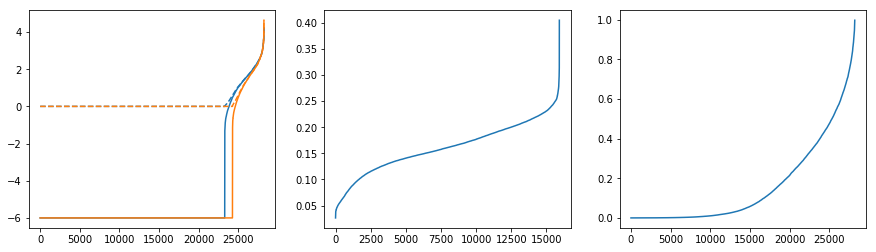

In [240]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
ax = axs[0]
ax.plot(df.iloc[: , 1].sort_values().values, '-', color='C0')
ax.plot(df2.iloc[: , 1].sort_values().values, '--', color='C0')
ax.plot(df.iloc[: , 2].sort_values().values, '-', color='C1')
ax.plot(df2.iloc[: , 2].sort_values().values, '--', color='C1')

ax = axs[1]
# cell
ax.plot(cell_rank.values)
# ax.plot((df>0).sum().sort_values().values)

ax = axs[2]
# gene
ax.plot(gene_rank.values)
# ax.plot((df>0).sum().sort_values().values)
plt.show()

In [248]:
# remove genes
df_f = df.loc[gene_rank[gene_rank > 0.7].index]
df_f2 = df2.loc[gene_rank[gene_rank > 0.7].index]


In [264]:
# imputation
df_f_copy = df_f.copy()
df_f_copy[df_f < 0] = np.nan
means = df_f_copy.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_f_copy.columns})
df_f_copy.fillna(fill_value, inplace=True)


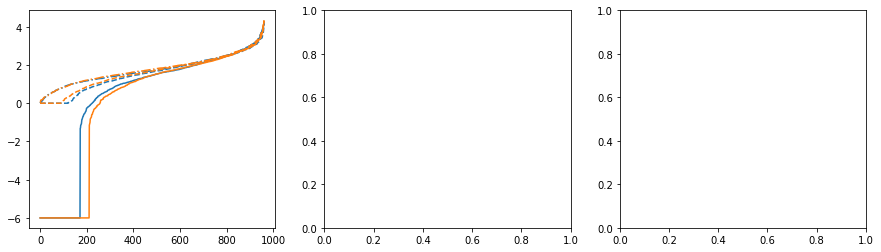

In [270]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
ax = axs[0]
ax.plot(df_f.iloc[: , 1].sort_values().values, '-', color='C0')
ax.plot(df_f2.iloc[: , 1].sort_values().values, '--', color='C0')
ax.plot(df_f_copy.iloc[: , 1].sort_values().values, '-.', color='C0')
ax.plot(df_f.iloc[: , 2].sort_values().values, '-', color='C1')
ax.plot(df_f2.iloc[: , 2].sort_values().values, '--', color='C1')
ax.plot(df_f_copy.iloc[: , 2].sort_values().values, '-.', color='C1')

# ax = axs[1]
# # cell
# ax.plot(((df_f>0).sum()/df_f.shape[0]).sort_values().values)
# # ax.plot((df>0).sum().sort_values().values)

# ax = axs[2]
# # gene
# ax.plot(((df_f>0).sum(axis=1)/df_f.shape[1]).sort_values().values)
# # ax.plot((df>0).sum().sort_values().values)
plt.show()

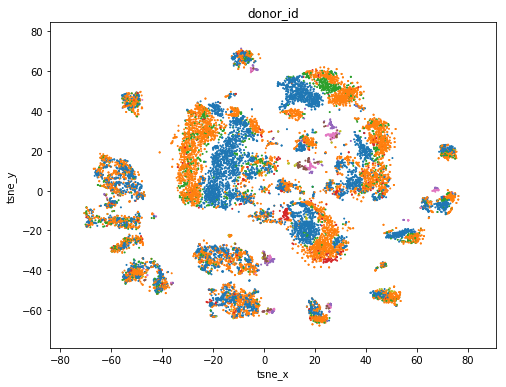

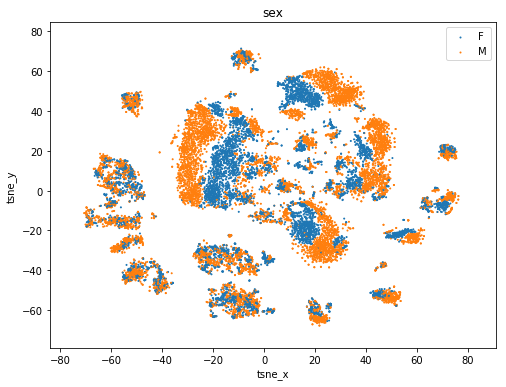

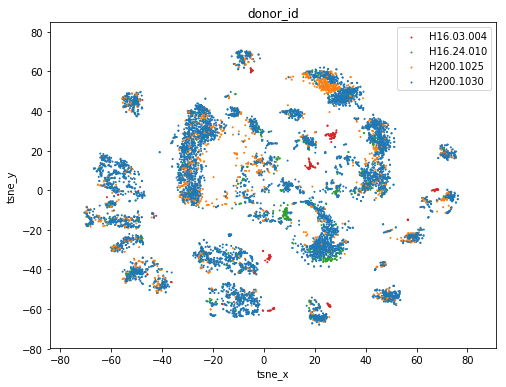

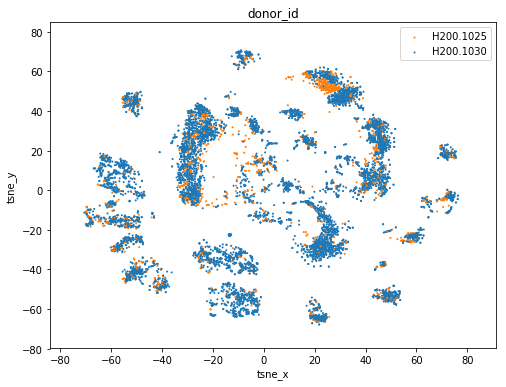

In [106]:
# snmcseq_utils.plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=-1)
snmcseq_utils.plot_tsne_labels(df_info, tc='donor_id', legend_mode=-1)
snmcseq_utils.plot_tsne_labels(df_info, tc='sex')
snmcseq_utils.plot_tsne_labels(df_info[(df_info['sex']=='M')], 
                               tc='donor_id', legend_mode=0)
snmcseq_utils.plot_tsne_labels(df_info[(df_info['sex']=='M') & (df_info['donor_id'].isin(['H200.1025', 'H200.1030']))], 
                               tc='donor_id', legend_mode=0)


# Annotate clusters

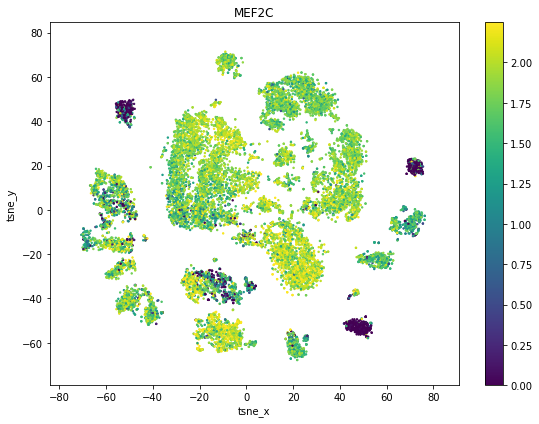

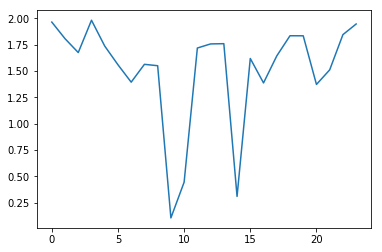

In [108]:
# gene expression tsne
gene_name = 'MEF2C'

# tsne 
sr_gene = df.loc[gene_name]

df_gene = pd.concat((df_info, sr_gene), axis=1)
snmcseq_utils.plot_tsne_values(df_gene, tc=gene_name)

# mean plot
res_mean = df_gene[['cluster_ID', gene_name]].groupby('cluster_ID').mean()
plt.plot(res_mean.values)
plt.show()

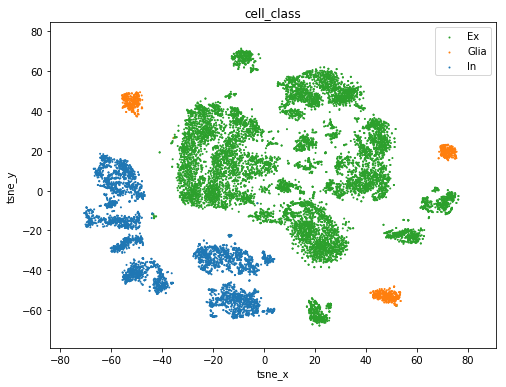

In [120]:
# annotate clusters, generate df_annot and df_info with annotation
annot_list = []

gene_name = 'MEF2C'
sr_gene = df.loc[gene_name]
df_gene = pd.concat((df_info, sr_gene), axis=1)
res_mean = df_gene[['cluster_ID', gene_name]].groupby('cluster_ID').mean()
for cluster_id in res_mean.loc[res_mean[gene_name] < 1].index:
    annot_list.append({'cluster_ID': cluster_id,
                      'cell_class': 'Glia'})

gene_name = 'SATB2'
sr_gene = df.loc[gene_name]
df_gene = pd.concat((df_info, sr_gene), axis=1)
res_mean = df_gene[['cluster_ID', gene_name]].groupby('cluster_ID').mean()
for cluster_id in res_mean.loc[res_mean[gene_name] > 0.3].index:
    annot_list.append({'cluster_ID': cluster_id,
                      'cell_class': 'Ex'})

gene_name = 'GAD1'
sr_gene = df.loc[gene_name]
df_gene = pd.concat((df_info, sr_gene), axis=1)
res_mean = df_gene[['cluster_ID', gene_name]].groupby('cluster_ID').mean()
for cluster_id in res_mean.loc[res_mean[gene_name] > 2].index:
    annot_list.append({'cluster_ID': cluster_id,
                      'cell_class': 'In'})

# df_annot
df_annot = pd.DataFrame(annot_list)
df_annot = df_annot.set_index('cluster_ID')
df_annot.sort_index()

# df_info includes annotation
df_info = pd.merge(df_info, df_annot, left_on='cluster_ID', right_index=True, how='inner')
snmcseq_utils.plot_tsne_labels(df_info, tc='cell_class')

In [121]:
# back-compatible
df_info['Biosample'] = df_info['donor_id'].values

# number of cells in each cluster across datasets

- ANOVA
- PCA-LDA
- Marker genes

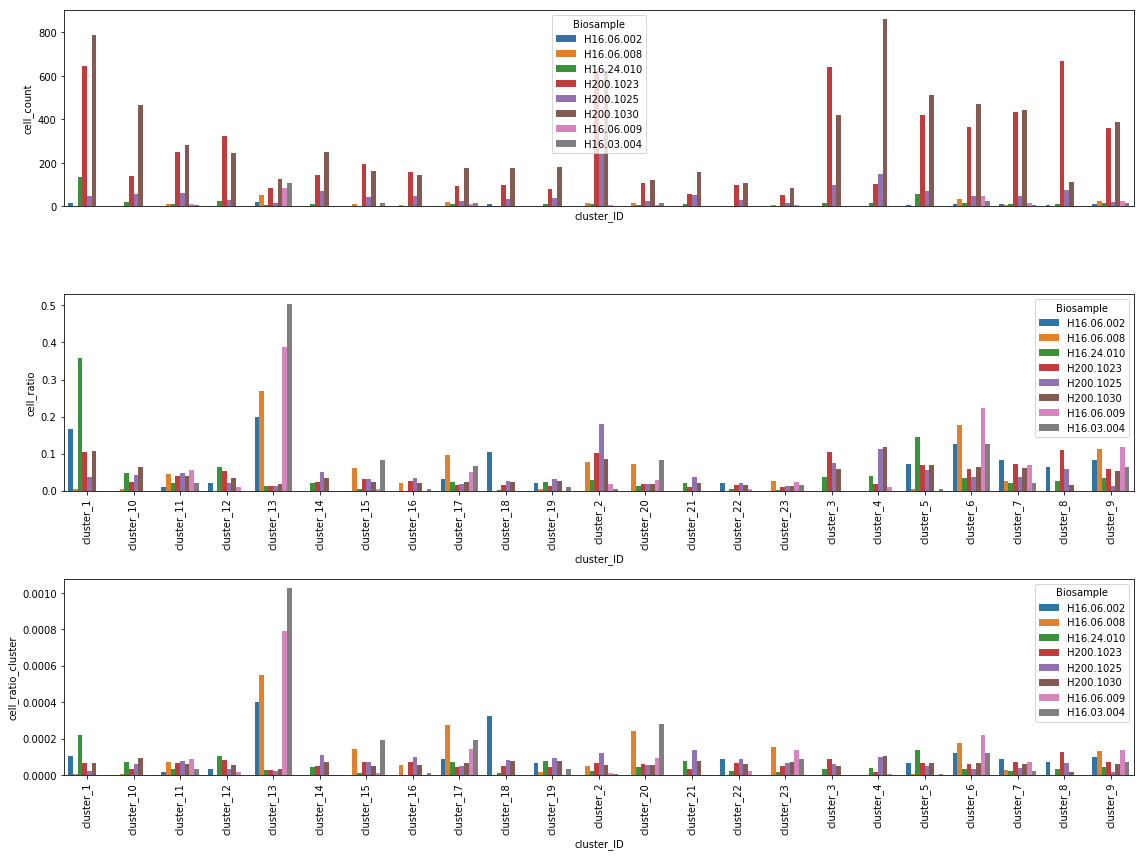

In [122]:
# bar1
df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['donor_id'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['donor_id'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['donor_id'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster

df_counts_new = df_counts_new.sort_values('cluster_ID')
# df_counts_new.head()

fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.tight_layout()
plt.show()

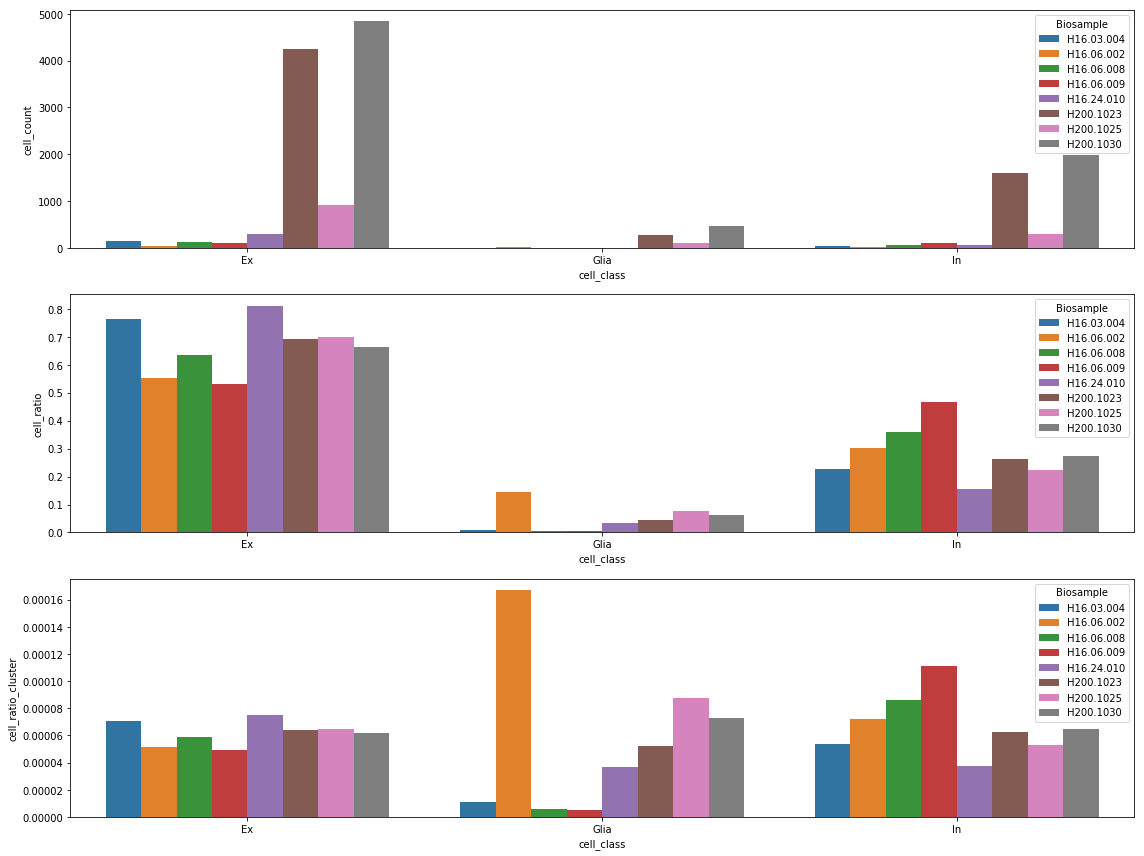

In [123]:
# bar3
df_counts_3 = df_info.groupby(['cell_class', 'Biosample']).count()['donor_id'].to_frame()
df_counts_3 = df_counts_3.reset_index(level=['cell_class', 'Biosample'])
df_counts_3.columns = ['cell_class', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['donor_id'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_3 = pd.merge(df_counts_3, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_3['cell_ratio'] = df_counts_new_3.cell_count/df_counts_new_3.tc_biosample

df_cluster_counts = df_info.groupby('cell_class').count()['donor_id'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_3 = pd.merge(df_counts_new_3, df_cluster_counts, left_on='cell_class', right_index=True)
df_counts_new_3['cell_ratio_cluster'] = df_counts_new_3.cell_ratio/df_counts_new_3.tc_cluster

fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cell_class", y="cell_count", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cell_class", y="cell_ratio", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cell_class", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_3, ax=ax)
fig.tight_layout()
plt.show()

# Sample data

In [271]:
# Trim data to compare only 2 individuals ?
df_info = df_info[df_info['Biosample'].isin(['H200.1023', 'H200.1030'])]
df_f_copy = df_f_copy[df_info.index.values]

print(df_info.shape)
print(df_f2.shape)

(13430, 61)
(961, 13430)


In [ ]:
# Trim data to sample equal # of cells from each individuals

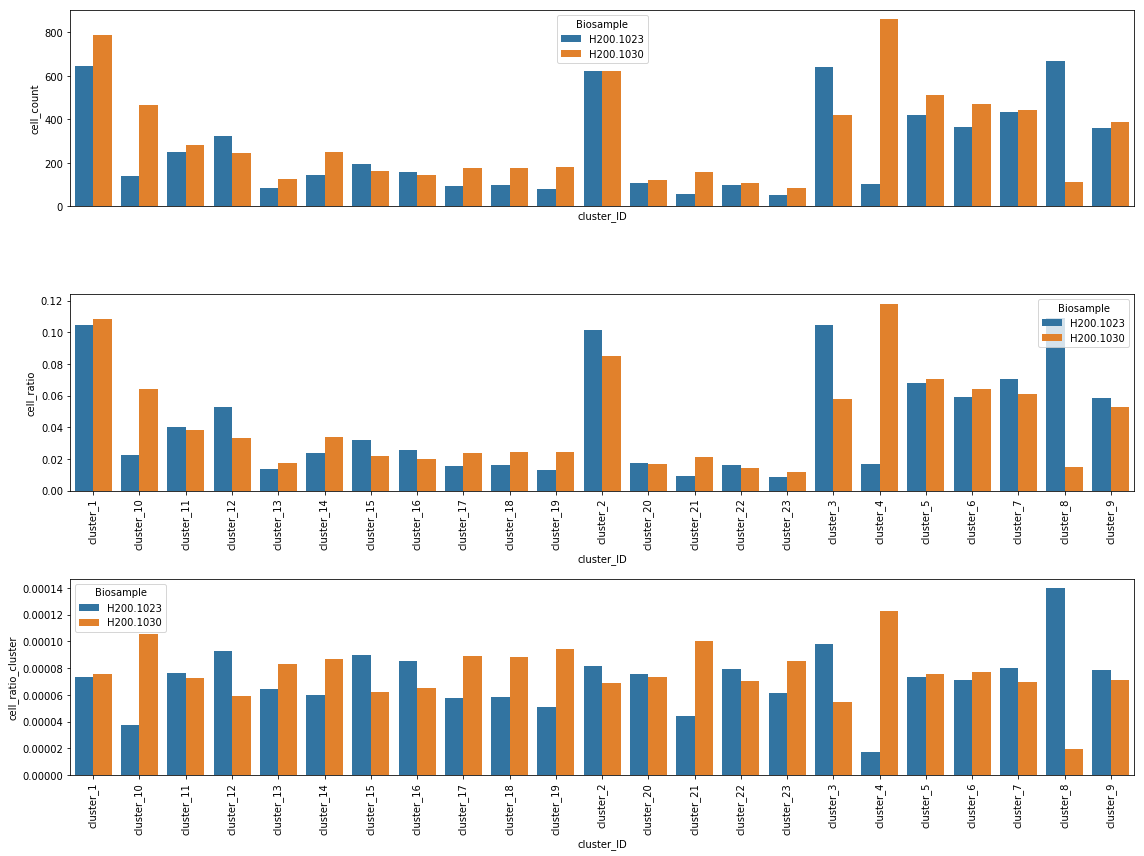

In [191]:
# cell distribution
df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['donor_id'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['donor_id'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample

df_cluster_counts = df_info.groupby('cluster_ID').count()['donor_id'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster
df_counts_new = df_counts_new.sort_values('cluster_ID')

fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.tight_layout()
plt.show()

# ANOVA

In [272]:
# backcompatible
df_mcc = df_f_copy
print(df_mcc.shape)
print(df_info.shape)

(961, 13430)
(13430, 61)


In [273]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

In [274]:
# ANOVAs for each gene
# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()

for idx, df_sub in df_info.groupby('cluster_ID'):
    logging.info(idx)
    cells = df_sub.index.values
    SSt = df_mcc[cells].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        logging.info(idx2)
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

03/01/2018 05:18:00 PM cluster_1
03/01/2018 05:18:00 PM H200.1023
03/01/2018 05:18:01 PM H200.1030
03/01/2018 05:18:01 PM cluster_10
03/01/2018 05:18:01 PM H200.1023
03/01/2018 05:18:01 PM H200.1030
03/01/2018 05:18:02 PM cluster_11
03/01/2018 05:18:02 PM H200.1023
03/01/2018 05:18:02 PM H200.1030
03/01/2018 05:18:02 PM cluster_12
03/01/2018 05:18:03 PM H200.1023
03/01/2018 05:18:03 PM H200.1030
03/01/2018 05:18:03 PM cluster_13
03/01/2018 05:18:03 PM H200.1023
03/01/2018 05:18:03 PM H200.1030
03/01/2018 05:18:04 PM cluster_14
03/01/2018 05:18:04 PM H200.1023
03/01/2018 05:18:04 PM H200.1030
03/01/2018 05:18:04 PM cluster_15
03/01/2018 05:18:04 PM H200.1023
03/01/2018 05:18:05 PM H200.1030
03/01/2018 05:18:05 PM cluster_16
03/01/2018 05:18:05 PM H200.1023
03/01/2018 05:18:05 PM H200.1030
03/01/2018 05:18:06 PM cluster_17
03/01/2018 05:18:06 PM H200.1023
03/01/2018 05:18:06 PM H200.1030
03/01/2018 05:18:06 PM cluster_18
03/01/2018 05:18:06 PM H200.1023
03/01/2018 05:18:07 PM H200.1030
0

In [275]:
# F-stat, p-values

I = df_info['Biosample'].unique().shape[0]
print(str(I) + ' unique categories!')

df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
logging.info('df_F is ready')
df_p = pd.DataFrame()
for col in df_F.columns:
    logging.info('df_p {}'.format(col))
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

03/01/2018 05:18:14 PM df_F is ready
03/01/2018 05:18:14 PM df_p cluster_1
03/01/2018 05:18:15 PM df_p cluster_10


2 unique categories!


03/01/2018 05:18:15 PM df_p cluster_11
03/01/2018 05:18:15 PM df_p cluster_12
03/01/2018 05:18:15 PM df_p cluster_13
03/01/2018 05:18:15 PM df_p cluster_14
03/01/2018 05:18:15 PM df_p cluster_15
03/01/2018 05:18:15 PM df_p cluster_16
03/01/2018 05:18:16 PM df_p cluster_17
03/01/2018 05:18:16 PM df_p cluster_18
03/01/2018 05:18:16 PM df_p cluster_19
03/01/2018 05:18:16 PM df_p cluster_2
03/01/2018 05:18:16 PM df_p cluster_20
03/01/2018 05:18:16 PM df_p cluster_21
03/01/2018 05:18:16 PM df_p cluster_22
03/01/2018 05:18:17 PM df_p cluster_23
03/01/2018 05:18:17 PM df_p cluster_3
03/01/2018 05:18:17 PM df_p cluster_4
03/01/2018 05:18:17 PM df_p cluster_5
03/01/2018 05:18:17 PM df_p cluster_6
03/01/2018 05:18:17 PM df_p cluster_7
03/01/2018 05:18:17 PM df_p cluster_8
03/01/2018 05:18:18 PM df_p cluster_9


,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,...,cluster_21,cluster_22,cluster_23,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
name,,,,,,,,,,,,,,,,,,,,,
RPS18,0.000469,0.003140,0.770156,0.006508,0.000545,0.752299,0.167773,0.781705,0.108657,0.094948,...,0.085668,0.078690,0.862000,0.126817,0.729286,0.076968,0.245010,2.184496e-01,0.525701,0.005460
STAG3L2,0.000011,0.000390,0.018408,0.000993,0.272501,0.325482,0.010562,0.003187,0.051785,0.284613,...,0.190768,0.127852,0.501551,0.002697,0.632093,0.012533,0.001570,4.779108e-09,0.000100,0.499990
FAM126B,0.881594,0.022230,0.276211,0.464149,0.635409,0.839349,0.358634,0.322504,0.685670,0.738570,...,0.224432,0.645418,0.735082,0.154503,0.216565,0.456013,0.421110,9.460958e-01,0.011704,0.230877
OSBPL1A,0.475076,0.500131,0.188512,0.381417,0.889795,0.153832,0.251183,0.560650,0.113847,0.146071,...,0.433313,0.676912,0.618865,0.651925,0.009245,0.785171,0.761983,4.921135e-01,0.844420,0.060183
BASP1,0.000007,0.305899,0.162803,0.031350,0.572852,0.709828,0.250476,0.000362,0.138982,0.001208,...,0.825088,0.775517,0.203716,0.276716,0.021088,0.014482,0.391215,2.748953e-01,0.643619,0.750872


In [276]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

In [277]:
df_res_ordered2[['cluster_2', 'cluster_6']].head()

,cluster_2,cluster_6
0,0.277484,0.092696
1,0.268916,0.068424
2,0.251084,0.062640
3,0.214400,0.060552
4,0.121351,0.057063


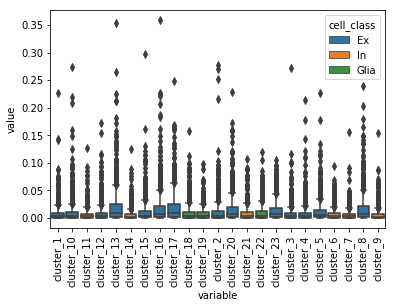

,cluster_1,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,...,cluster_21,cluster_22,cluster_23,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,2.268214e-01,2.735423e-01,1.267073e-01,1.730637e-01,3.535919e-01,1.256767e-01,2.969038e-01,3.585896e-01,2.493897e-01,1.572094e-01,...,1.071349e-01,1.197121e-01,1.048004e-01,2.722346e-01,2.140342e-01,2.270838e-01,9.388733e-02,1.565801e-01,2.703855e-01,1.539215e-01
1,1.437709e-01,2.198596e-01,9.232182e-02,1.538587e-01,2.643485e-01,8.893510e-02,1.613106e-01,2.266935e-01,1.692159e-01,1.123143e-01,...,9.149409e-02,1.057972e-01,9.533582e-02,1.152746e-01,1.779840e-01,1.774840e-01,6.961974e-02,9.081234e-02,2.388904e-01,8.798632e-02
2,1.408410e-01,2.090328e-01,8.621886e-02,1.164998e-01,2.256423e-01,8.205825e-02,1.300386e-01,2.254815e-01,1.668336e-01,1.006804e-01,...,8.972535e-02,8.610221e-02,9.529251e-02,1.012376e-01,1.437490e-01,1.345675e-01,6.383761e-02,8.275631e-02,2.030318e-01,8.693352e-02
3,8.945942e-02,1.604414e-01,7.853859e-02,1.151923e-01,2.122308e-01,7.705473e-02,1.207727e-01,2.215238e-01,1.634394e-01,9.875230e-02,...,8.625602e-02,7.821898e-02,8.967209e-02,1.005317e-01,1.220789e-01,1.224096e-01,6.174893e-02,6.952567e-02,1.793752e-01,7.042727e-02
4,8.749455e-02,1.480775e-01,7.574625e-02,1.017905e-01,2.118576e-01,7.159970e-02,1.149021e-01,2.061507e-01,1.620885e-01,9.010261e-02,...,7.885043e-02,7.682484e-02,8.678157e-02,1.005136e-01,1.106364e-01,1.154210e-01,5.826080e-02,4.942480e-02,1.644792e-01,6.767068e-02
5,7.681753e-02,1.245054e-01,6.842501e-02,1.017618e-01,1.806895e-01,5.722755e-02,1.135340e-01,1.861463e-01,1.592428e-01,8.988396e-02,...,7.547788e-02,7.400171e-02,8.626458e-02,9.972522e-02,1.094836e-01,1.124235e-01,5.488389e-02,4.913250e-02,1.496189e-01,6.429632e-02
6,7.534860e-02,1.071209e-01,6.346072e-02,9.474940e-02,1.729283e-01,5.350039e-02,1.076583e-01,1.824007e-01,1.475890e-01,8.959126e-02,...,7.278873e-02,7.252491e-02,8.436099e-02,8.268996e-02,9.584365e-02,1.035158e-01,5.485118e-02,4.655323e-02,1.488601e-01,6.342478e-02
7,7.375218e-02,9.858512e-02,5.210928e-02,9.331167e-02,1.575754e-01,4.818875e-02,1.040858e-01,1.622183e-01,1.352296e-01,8.939647e-02,...,6.984716e-02,6.981136e-02,8.344120e-02,7.427751e-02,8.400149e-02,9.001945e-02,5.013734e-02,4.507770e-02,1.422372e-01,6.110769e-02
8,7.177029e-02,9.509905e-02,5.147579e-02,8.460095e-02,1.532188e-01,4.786563e-02,1.012204e-01,1.495316e-01,1.324132e-01,8.587680e-02,...,6.935669e-02,6.737564e-02,7.959187e-02,7.281767e-02,8.190525e-02,8.473145e-02,4.874235e-02,4.397049e-02,1.369064e-01,5.756371e-02
9,6.997654e-02,9.221486e-02,5.097612e-02,8.404784e-02,1.495601e-01,4.528238e-02,9.827662e-02,1.402336e-01,1.276790e-01,8.511481e-02,...,6.156034e-02,6.359261e-02,7.931398e-02,6.968390e-02,7.704815e-02,8.451297e-02,4.837578e-02,4.359699e-02,1.337012e-01,5.710022e-02


In [278]:
fig, ax = plt.subplots()
sns.boxplot(x='variable', y='value', 
            data=pd.merge(pd.melt(df_res_ordered1), df_annot, left_on='variable', right_index=True), dodge=False,
            ax=ax, hue='cell_class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

df_res_ordered1

## Plots of ANOVA

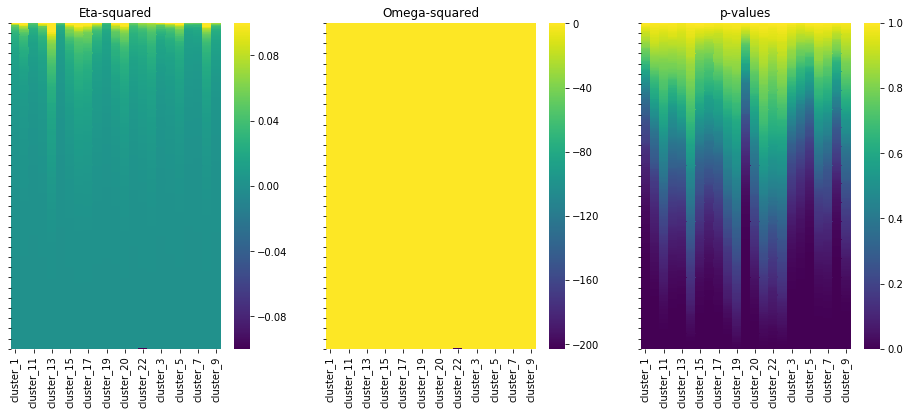

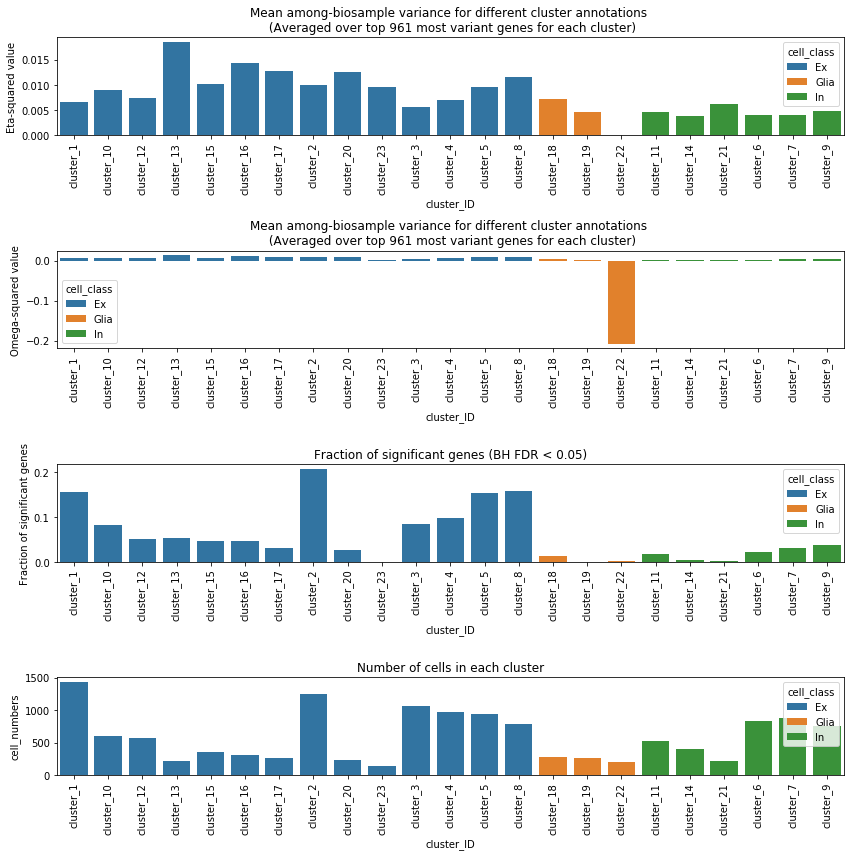

In [279]:
# eta-squared, omega-squared, and p-values 
# colors = {'Ex': 'C0', 'Glia': 'C1', 'In': 'C2'}

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 
# n_top = 1000

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['cluster_ID', 'Eta-squared value']
df_plot1 = pd.merge(df_plot1, df_annot, left_on='cluster_ID', right_index=True).sort_values(['cell_class', 'cluster_ID'])

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['cluster_ID', 'Omega-squared value']
df_plot2 = pd.merge(df_plot2, df_annot, left_on='cluster_ID', right_index=True).sort_values(['cell_class', 'cluster_ID'])

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['cluster_ID', 'Fraction of significant genes']
df_plot3 = pd.merge(df_plot3, df_annot, left_on='cluster_ID', right_index=True).sort_values(['cell_class', 'cluster_ID'])

# number of cells in each 
df_plot4 = pd.merge(sr_n.to_frame().rename(columns={0: 'cell_numbers'}), df_plot1, 
                    left_index=True, right_on='cluster_ID').sort_values(['cell_class', 'cluster_ID'])

# # colors
# cs = [colors[cell_class] for cell_class in df_plot1['cell_class']]

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='cluster_ID', y='Eta-squared value', data=df_plot1, ax=ax, hue='cell_class', dodge=False)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = axs[1]
sns.barplot(x='cluster_ID', y='Omega-squared value', data=df_plot2, ax=ax, hue='cell_class', dodge=False)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = axs[2]
sns.barplot(x='cluster_ID', y='Fraction of significant genes', data=df_plot3, ax=ax, hue='cell_class', dodge=False)
ax.set_title('Fraction of significant genes (BH FDR < 0.05)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = axs[3]
sns.barplot(x='cluster_ID', y='cell_numbers', data=df_plot4, ax=ax, hue='cell_class', dodge=False)
ax.set_title('Number of cells in each cluster')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.tight_layout()
plt.show()



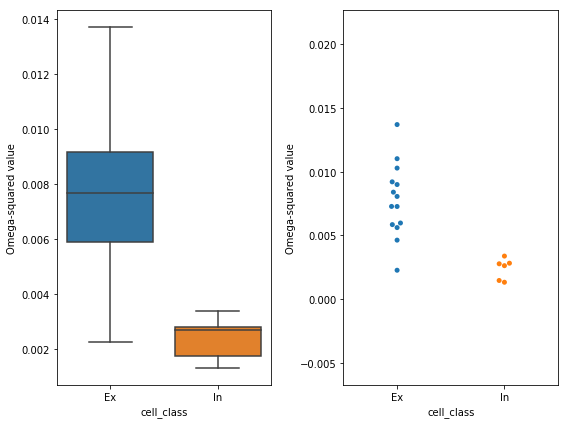

In [283]:

fig, axs = plt.subplots(1, 2, figsize=(8, 6))
ax = axs[0]
sns.boxplot(x='cell_class', y='Omega-squared value', data=df_plot2[df_plot2['cell_class']!='Glia'], ax=ax)
ax = axs[1]
sns.swarmplot(x='cell_class', y='Omega-squared value', data=df_plot2[df_plot2['cell_class']!='Glia'], ax=ax)
fig.tight_layout()
plt.show()

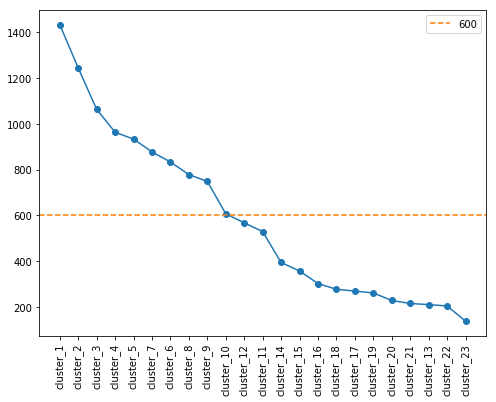

cluster_1     1433
cluster_10     607
cluster_2     1244
cluster_3     1063
cluster_4      963
cluster_5      933
cluster_6      833
cluster_7      877
cluster_8      778
cluster_9      748
dtype: int64

In [287]:
sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=600, ls='dashed', color='C1', label='600')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 600)].index)]
sr_n_tr

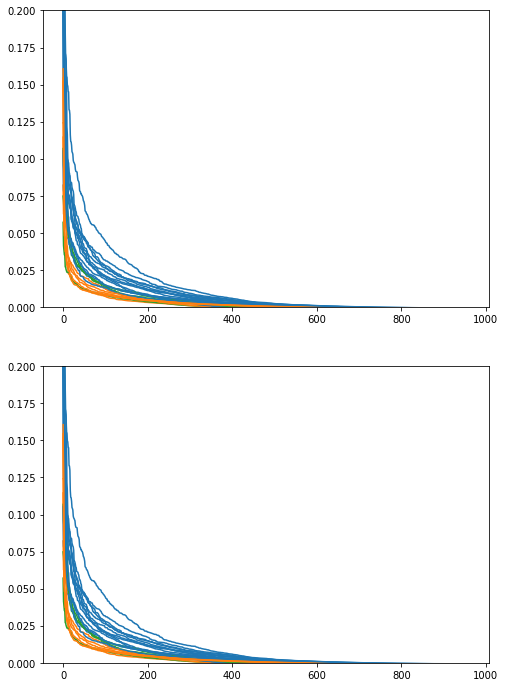

In [284]:
# eta-squared
df_cell_class = df_annot

# cell_types_tr = sr_n_tr.index.tolist()
# df_res = df_ome[cell_types_tr] 

df_res = df_ome 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 6*2))

ax = axs[0]
n_tops = 10000
for col in df_res.columns:
    values = df_res_ordered[col].values
    values = values[~np.isnan(values)]
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(values[:n_tops], label='Ex', color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(values[:n_tops], label='In', color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(values[:n_tops], label='Glia', color='C2')
ax.set_ylim([0, 0.2])
# ax.legend()

ax = axs[1]
n_tops = 2000
for col in df_res.columns:
    values = df_res_ordered[col].values
    values = values[~np.isnan(values)]
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(values[:n_tops], label='Ex', color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(values[:n_tops], label='In', color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(values[:n_tops], label='Glia', color='C2')
ax.set_ylim([0, 0.2])
# ax.legend()

plt.show()



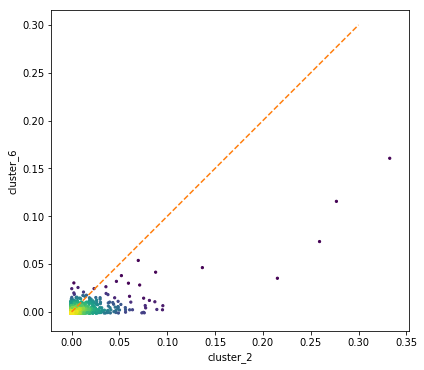

In [285]:
# ome pairwise distribution
df_res = df_ome
fig, ax = plt.subplots(figsize=(6, 6))
# xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
x = df_res['cluster_2'].values
y = df_res['cluster_6'].values
xy = np.asarray([(a, b) for a, b in zip(x, y) if not (np.isnan(a) or np.isnan(b))]).T
x = xy[0]
y = xy[1]
z = gaussian_kde(xy)(xy)
ax.scatter(x, y, c=np.log10(z), s=5)
ax.set_xlabel('cluster_2')
ax.set_ylabel('cluster_6')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')
# ax.set_xlim([-0.01, 0.4])
# ax.set_ylim([-0.01, 0.4])
fig.tight_layout()
plt.show()

# classifier

In [305]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype):
    # generate data
    cells = df_info[df_info['cluster_ID']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells].T 
#     X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells].T 
#     X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    return df_xy0, df_xy1
    

In [332]:
def LDA_xvalid(df_xy, n_splits=5, n_tops=np.arange(1, 100, 2), classifier='LDA'):
    """
    X = regex="^ENS"
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
#     xcols = np.delete(df_xy.columns.values, -1)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            
            X_train = df_xy.iloc[train_index, :n_top]
            X_test = df_xy.iloc[test_index, :n_top]
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            if classifier == 'LDA':
                lda = LDA().fit(X_train, y_train)
                y_pred = lda.predict(X_test)
            elif classifier == 'RFC':
                rfc = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
                y_pred = rfc.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f1_micros, mean_f1_macros


In [333]:
def LDA_pca_xvalid(X, y, n_splits=5, classifier='LDA', metric_auroc=False):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    if metric_auroc:
        mean_aurocs = []
    split_scheme = list(kf.split(y))
 
    accs = []
    f1_micros = []
    f1_macros = []
    if metric_auroc:
        aurocs = []
    for i, (train_index, test_index) in enumerate(split_scheme):
        X_train = X[train_index] 
        X_test = X[test_index] 
        y_train = y[train_index] 
        y_test = y[test_index] 

        # train LDA model
        if classifier == 'LDA':
            res_fit = LDA().fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
            y_pred_p = res_fit.predict_proba(X_test)[:,0]
        elif classifier == 'RFC':
            res_fit = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
            y_pred_p = res_fit.predict_proba(X_test)[:,0]

        # evaluate
        acc = metrics.accuracy_score(y_test, y_pred)
        f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
        f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
        
        accs.append(acc)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)

        if metric_auroc:
            y_factors, y_labels = pd.factorize(y_test) 
            fpr, tpr, thresholds = metrics.roc_curve(y_factors, y_pred_p)
            auroc = metrics.auc(fpr, tpr)
            aurocs.append(auroc)
#         if i == 0:
#             conf_mat = metrics.confusion_matrix(y_test, y_pred)
#             print(conf_mat)


    mean_acc = np.mean(accs)
    mean_f1_micro = np.mean(f1_micros)
    mean_f1_macro = np.mean(f1_macros)
    if metric_auroc:
        mean_auroc = np.mean(aurocs)
    if metric_auroc:
        return mean_acc, mean_f1_micro, mean_f1_macro, mean_auroc
    else:
        return mean_acc, mean_f1_micro, mean_f1_macro


In [323]:
# PCA regression
# top n PCs
n_tops = [5, 10, 20, 30, 40, 50]

cell_types_tr2 = sr_n_tr.index.values

res_dct = OrderedDict()
for celltype in cell_types_tr2:
    print(celltype)
    df_xy0, df_xy1 = get_data(celltype)
    xcols = np.delete(df_xy1.columns.values, -1)
    X = df_xy1[xcols].values
    y = df_xy1.Biosample.values
    
    accs = []
    f1_mis = []
    f1_mas = []
    aurocs = []
    for n_top in n_tops:
        print(n_top, end=' ')
        pca = PCA(n_components=n_top)
        pcX = pca.fit_transform(X)

        acc, f1_mi, f1_ma, auroc = LDA_pca_xvalid(pcX, y, classifier='LDA', metric_auroc=True)
        accs.append(acc)
        f1_mis.append(f1_mi)
        f1_mas.append(f1_ma)
        aurocs.append(auroc)
    
    res_dct[celltype] = (accs, f1_mis, f1_mas, aurocs) 

cluster_1
51020304050cluster_10
51020304050cluster_2
51020304050cluster_3
51020304050cluster_4
51020304050cluster_5
51020304050cluster_6
51020304050cluster_7
51020304050cluster_8
51020304050cluster_9
51020304050

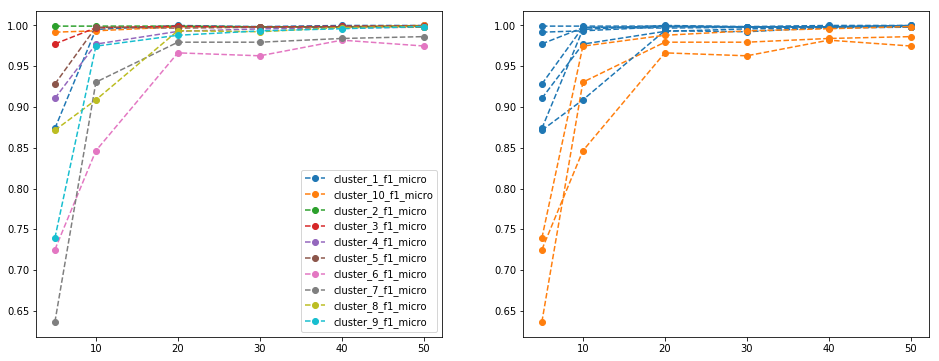

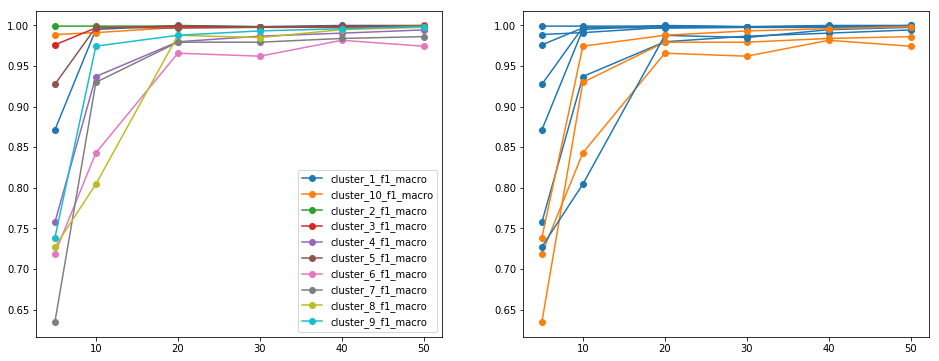

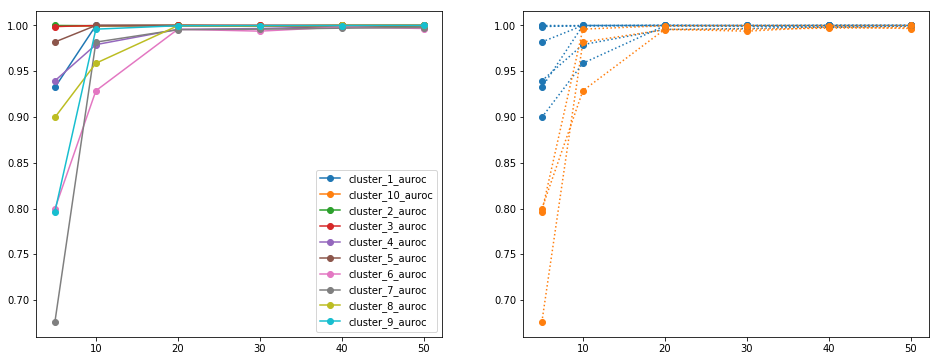

In [324]:
# plot PCA regression results
# cell_types_tr2 = sr_n_tr.index.values
# n_tops = [5, 10, 20, 30, 40, 50]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# micro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][3], ':o', color=colors[i%len(colors)], label='{}_auroc'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][3], ':o', color=c, label='{}_auroc'.format(celltype))
# ax.legend()
plt.show()


# macro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()
plt.show()


# auroc 
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][3], '-o', color=colors[i%len(colors)], label='{}_auroc'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][3], ':o', color=c, label='{}_auroc'.format(celltype))
# ax.legend()
plt.show()

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


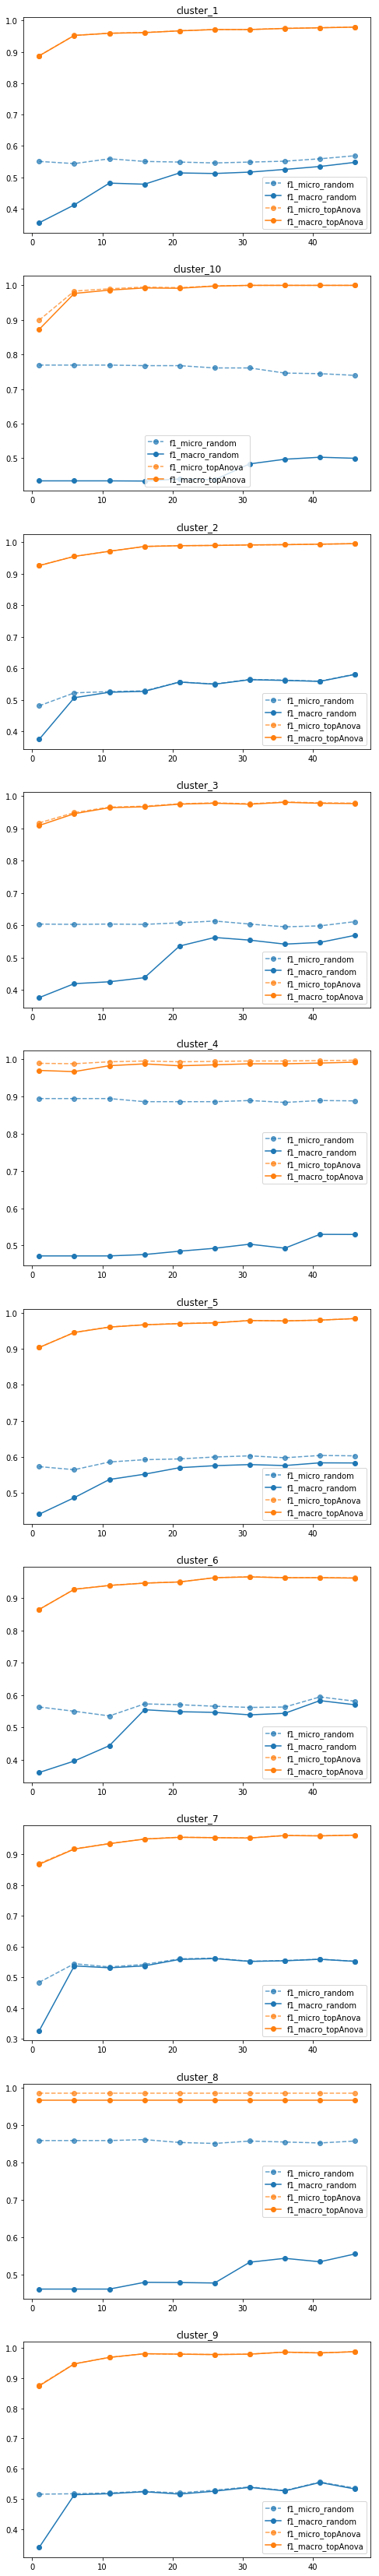

In [334]:
# LDA top genes
n = len(cell_types_tr2)
n_tops = np.arange(1, 50, 5)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0, n_tops=n_tops, classifier='LDA')
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1, n_tops=n_tops, classifier='LDA')

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [291]:
# What are the top 30 genes?
n_top = 20
cell_types_tr2 = sr_n_tr.index.values
top_genes = pd.DataFrame()
for celltype in cell_types_tr2:
    sr_top_genes = df_p[celltype].sort_values().index.values[:n_top]
    top_genes[celltype] = sr_top_genes
top_genes

,cluster_1,cluster_10,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,AHI1,NPIPA5,NPIPA5,AHI1,AHI1,AHI1,NPIPA5,AHI1,ANKRD36B,AHI1
1,STRC,ANKRD36B,AHI1,NPIPA5,USP32P1,TARBP1,AHI1,NPIPA5,AHI1,NPIPA5
2,NPIPA5,AHI1,ANKRD36B,CCDC88A,NPIPA5,NPIPA5,ANKRD36B,TARBP1,NPIPA5,STRC
3,ANKRD36B,TARBP1,TARBP1,TARBP1,CCDC144A,NPIPA1,STRC,STRC,ENC1,CCDC88A
4,TARBP1,SRSF5,MNAT1,NPIPA1,STRC,STRC,MNAT1,NPIPA1,GRIA2,TARBP1
5,CLU,CLK1,GRIA2,NRGN,CLK1,PKD1P6,CCDC88A,HMGN3-AS1,CALM2,SPARCL1
6,SPARCL1,BMS1P6,BMS1P6,PKD1P6,ANKRD36B,TUBA1B,CBWD5,STAG3L2,ARPP19,BCL2L2-PABPN1
7,NPIPA1,ARID4B,SRSF5,PABPN1,SNTG1,ANKRD36B,TARBP1,HSP90AA1,RTN4,PABPN1
8,LUC7L3,NPIPA1,CCDC88A,BCL2L2-PABPN1,MPP6,CCDC88A,RPL21,SRRM4,MYO6,SRSF5
9,TUBA1B,NDFIP1,CLU,BCYRN1,STMN2,SPARCL1,PEG3,SRSF11,LENG9,NDFIP1


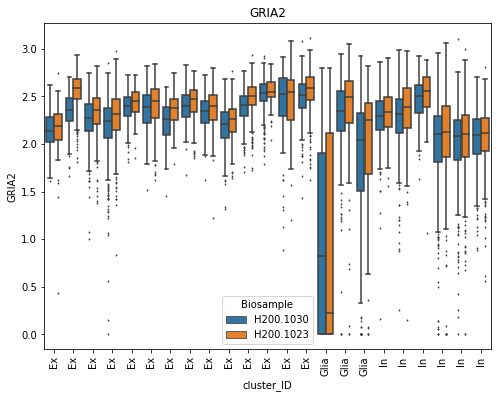

In [296]:
gene_list = ['GRIA2']
for gene_name in gene_list: 
    dfg = pd.merge(df_info, df2.loc[gene_name, :].to_frame(), 
                       left_index=True, right_index=True)
    order = df_cell_class.sort_values('cell_class').index.tolist()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x='cluster_ID', y=gene_name, hue='Biosample', 
                order=order, fliersize=1, 
                data=dfg, ax=ax)
    # yrange = [np.nanpercentile(dfg[gene_name].values, 5), np.nanpercentile(dfg[gene_name].values, 95)]
    # yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    # yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    # ax.set_ylim(yrange)
    # ax.set_ylim([-1, 4.5])
    # ax.set_ylim([-6.5, -5.5])
    ax.set_xticklabels([df_cell_class.loc[item.get_text(), 'cell_class'] 
                        for item in ax.get_xticklabels()], rotation=90)
    ax.set_title(gene_name)
    plt.show()

In [292]:
# What are the genes 
genes, counts = np.unique(top_genes.values.flatten(), return_counts=True)
top_genes_stats = pd.DataFrame()
top_genes_stats['gene_name'] = genes
top_genes_stats['number_of_occurance'] = counts
top_genes_stats = top_genes_stats.sort_values('number_of_occurance', ascending=False)
top_genes_stats.head(5)

,gene_name,number_of_occurance
0,AHI1,10
54,NPIPA5,10
80,STRC,9
1,ANKRD36B,9
16,CCDC88A,9


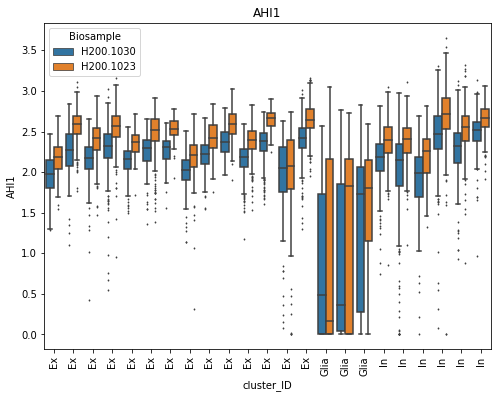

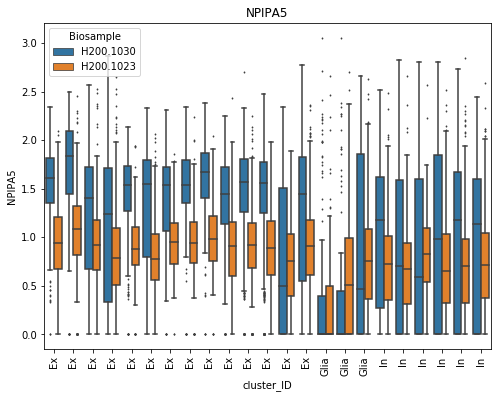

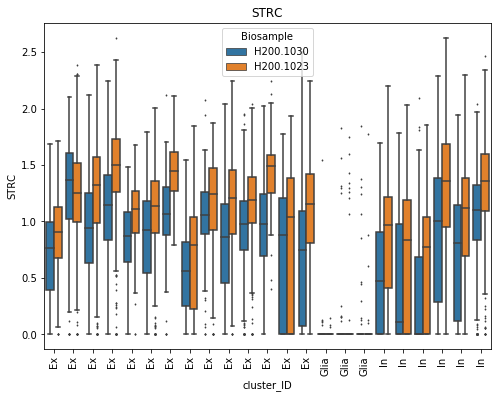

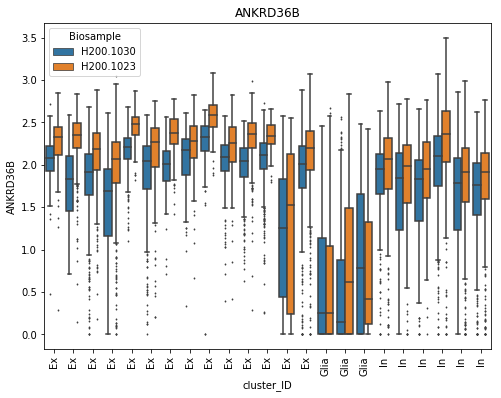

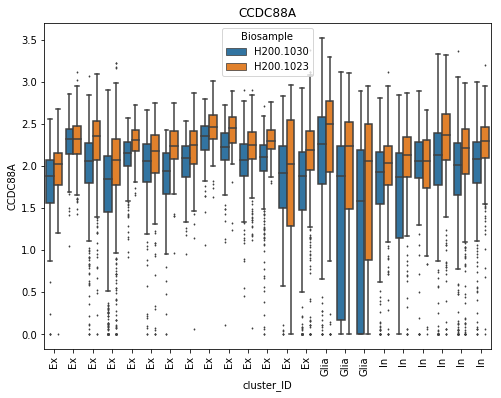

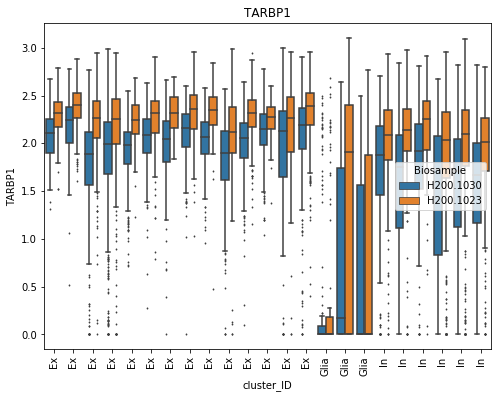

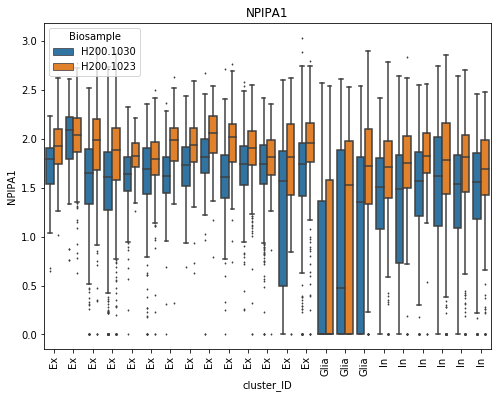

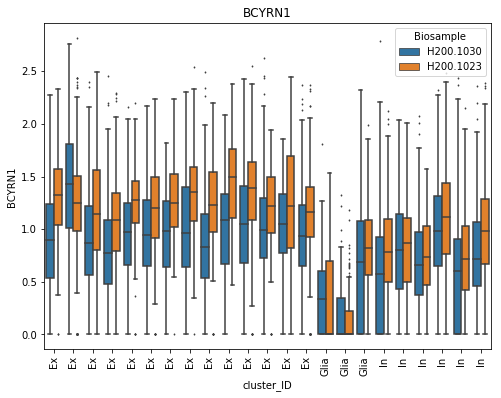

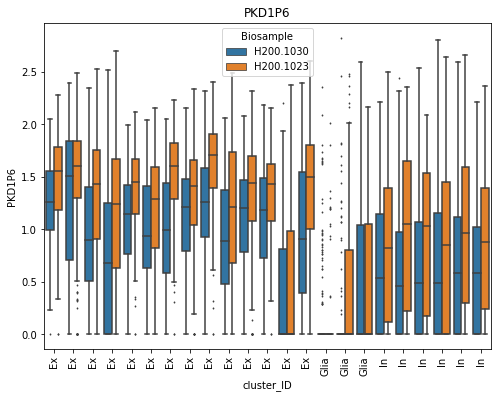

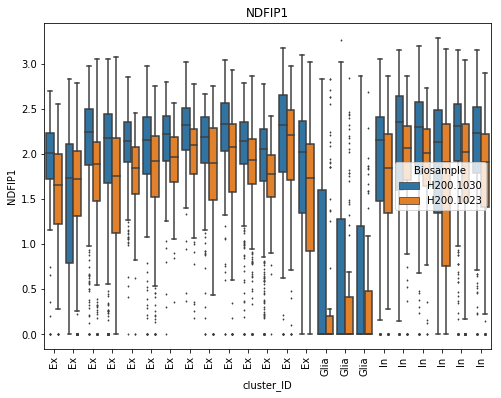

In [295]:
# df.loc['TSIX', :].to_frame()
for gene_name in top_genes_stats.gene_name[:10]: 
    dfg = pd.merge(df_info, df2.loc[gene_name, :].to_frame(), 
                       left_index=True, right_index=True)
    order = df_cell_class.sort_values('cell_class').index.tolist()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x='cluster_ID', y=gene_name, hue='Biosample', 
                order=order, fliersize=1, 
                data=dfg, ax=ax)
    # yrange = [np.nanpercentile(dfg[gene_name].values, 5), np.nanpercentile(dfg[gene_name].values, 95)]
    # yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    # yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    # ax.set_ylim(yrange)
    # ax.set_ylim([-1, 4.5])
    # ax.set_ylim([-6.5, -5.5])
    ax.set_xticklabels([df_cell_class.loc[item.get_text(), 'cell_class'] 
                        for item in ax.get_xticklabels()], rotation=90)
    ax.set_title(gene_name)
    plt.show()

In [ ]:
# boxplot
# Look at those genes in detail
# boxplot 3C vs 4B

for gene_name in top_genes_stats.gene_name[:3]:
    df.
    dfg['mCH/CH'] = dfg.mCH/dfg.CH
    dfg['mCH/CH_norm'] = dfg['mCH/CH']/dfg['global_mCH']
    dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
    dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
    order = sorted(dfg[annot_col].unique().tolist())
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    ax = axs[0]
    sns.boxplot(x=annot_col, y='mCH/CH', hue='region', order=order, data=dfg, ax=ax)
    yrange = [np.nanpercentile(dfg['mCH/CH'].values, 1), np.nanpercentile(dfg['mCH/CH'].values, 99)]
    yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(gene_name)
    
    ax = axs[1]
    sns.boxplot(x=annot_col, y='mCH/CH_norm', hue='region', order=order, data=dfg, ax=ax)
    yrange = [np.nanpercentile(dfg['mCH/CH_norm'].values, 1), np.nanpercentile(dfg['mCH/CH_norm'].values, 99)]
    yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(gene_name)
    plt.show()
    